# Q1

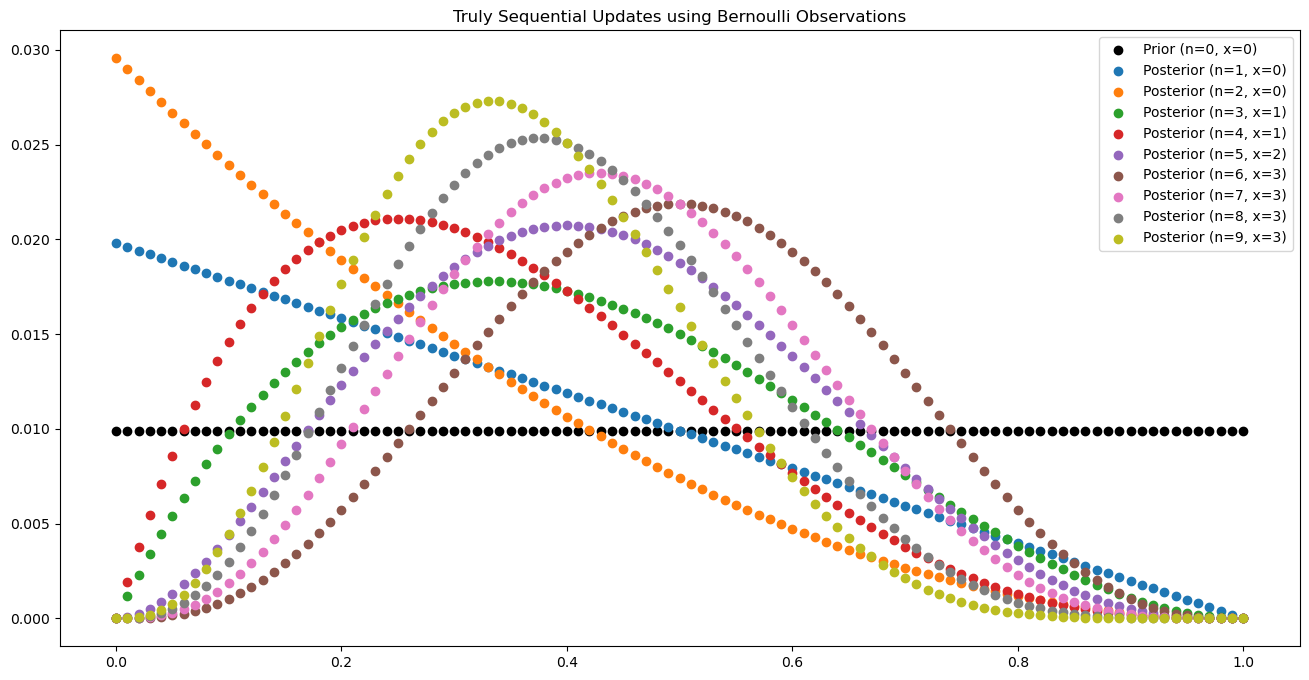

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Discretize the parameter space: 0, 1/100, 2/100, ..., 1
parameter_domain = np.linspace(0, 1, 101)

# Initialize a uniform prior distribution over these 101 points
prior = np.ones(101) / 101

# Observations (each observation is either 0 or 1)
observations = [0, 0, 1, 0, 1, 1, 0, 0, 0]

# Counters: n is the total number of observations so far, 
# x is the total number of successes so far.
n, x = 0, 0

plt.figure(figsize=(16, 8))
# Plot the initial prior
plt.scatter(parameter_domain, prior, label=f"Prior (n={n}, x={x})", color='black')
plt.title("Truly Sequential Updates using Bernoulli Observations")

# Perform the sequential update after each observation
for obs in observations:
    # Increase the total count by 1
    n += 1
    # Increase the number of successes by the current observation value
    x += obs
    
    # Unnormalized posterior = prior * likelihood for the current observation
    # If obs == 1, likelihood is theta; if obs == 0, likelihood is (1 - theta).
    posterior_unnormalized = prior * (parameter_domain ** obs) * ((1 - parameter_domain) ** (1 - obs))
    
    # Normalize the posterior so that its total sum is 1
    posterior = posterior_unnormalized / np.sum(posterior_unnormalized)
    
    # Plot the posterior distribution
    plt.scatter(parameter_domain, posterior, label=f"Posterior (n={n}, x={x})")
    
    # The current posterior becomes the prior for the next update
    prior = posterior

plt.legend()
plt.show()


$
\text{Since the prior is uniform on }[0,1]\text{ (i.e.\ Beta}(1,1)\text{), 
the posterior after observing }n\text{ Bernoulli trials with }x\text{ successes is:}
$
$
p(\theta \mid x,n) \;=\; \mathrm{Beta}\!\bigl(\theta \mid x+1,\;n-x+1\bigr).
$

$
\textbf{Posterior: } p(\theta \mid x,n) 
= \mathrm{Beta}\bigl(x+1,\;n - x +1\bigr).
$
$
\text{In other words, with the shape-parameterization, we have: }
\alpha = x + 1,\quad \beta = (n - x) + 1.
$
$
\text{Hence the posterior PDF is } 
p(\theta \mid x,n)
= \frac{\Gamma\bigl(\alpha+\beta\bigr)}{\Gamma(\alpha)\,\Gamma(\beta)} 
\,\theta^{\,\alpha - 1}
\,(1 - \theta)^{\,\beta - 1}
,\quad 0 \le \theta \le 1.
$


# Q2

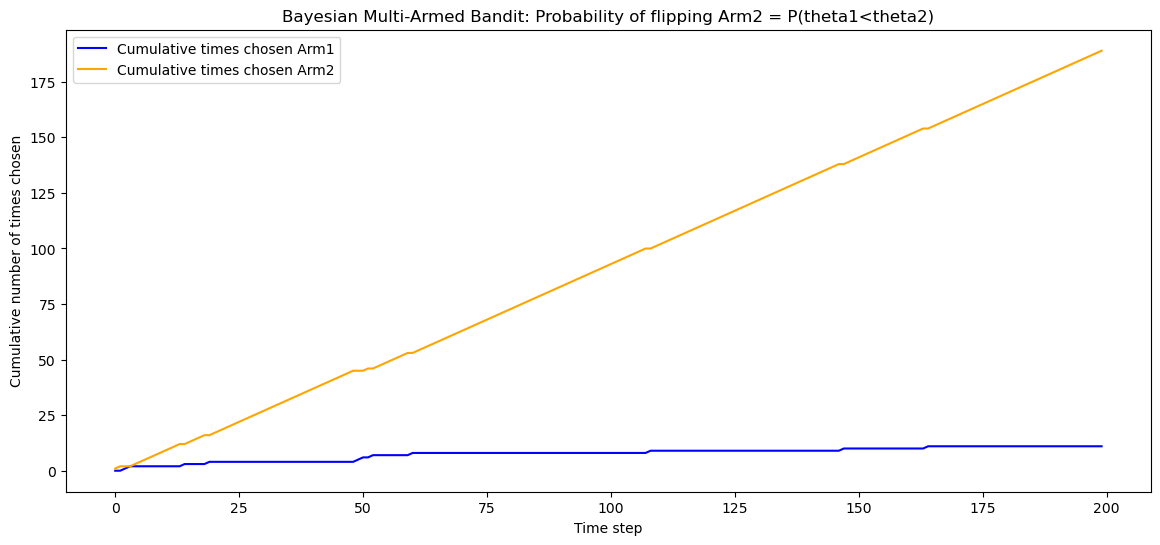

Final estimates for arm1: alpha1=2, beta1=11, => mean=0.15384615384615385
Final estimates for arm2: alpha2=112, beta2=79, => mean=0.5863874345549738
Ground truth: theta1_true=0.3, theta2_true=0.6


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist

def approximate_prob_theta1_less_than_theta2(a1, b1, a2, b2, num_samples=10000):
    """
    Approximate P(theta1 < theta2) by Monte Carlo (蒙特卡洛 Monte Carlo) sampling
    from Beta(a1, b1) and Beta(a2, b2).
    """
    samples_1 = np.random.beta(a1, b1, size=num_samples)
    samples_2 = np.random.beta(a2, b2, size=num_samples)
    return np.mean(samples_1 < samples_2)

# True success probabilities for arm1 and arm2
theta1_true = 0.3
theta2_true = 0.6

# Initialize counters for each arm:
# n_j = total flips, x_j = number of successes
n1, x1 = 0, 0
n2, x2 = 0, 0

# Hyperparameters for Beta prior (starting with Beta(1,1))
alpha1, beta1 = 1, 1
alpha2, beta2 = 1, 1

# We'll run for m steps
m = 200

# Keep track of which arm was chosen each step
chosen_arms = []

for t in range(m):
    # Compute P(theta1 < theta2) given current posterior
    p_1_less_2 = approximate_prob_theta1_less_than_theta2(alpha1, beta1, alpha2, beta2)
    
    # Decide which arm to flip:
    # with probability p_1_less_2 => flip arm2, else flip arm1
    if np.random.rand() < p_1_less_2:
        # Flip arm2
        chosen_arm = 2
        # Generate a success/fail according to theta2_true
        outcome = (np.random.rand() < theta2_true)
        # Update counts
        n2 += 1
        x2 += outcome
        # Update posterior parameters
        alpha2 = x2 + 1
        beta2 = (n2 - x2) + 1
    else:
        # Flip arm1
        chosen_arm = 1
        # Generate a success/fail according to theta1_true
        outcome = (np.random.rand() < theta1_true)
        # Update counts
        n1 += 1
        x1 += outcome
        # Update posterior parameters
        alpha1 = x1 + 1
        beta1 = (n1 - x1) + 1
    
    chosen_arms.append(chosen_arm)

# Plot results
plt.figure(figsize=(14,6))

# 1) plot how many times each arm was chosen up to step t
times_chosen_arm1 = np.cumsum([1 if a == 1 else 0 for a in chosen_arms])
times_chosen_arm2 = np.cumsum([1 if a == 2 else 0 for a in chosen_arms])

plt.plot(times_chosen_arm1, label='Cumulative times chosen Arm1', color='blue')
plt.plot(times_chosen_arm2, label='Cumulative times chosen Arm2', color='orange')
plt.title("Bayesian Multi-Armed Bandit: Probability of flipping Arm2 = P(theta1<theta2)")
plt.xlabel("Time step")
plt.ylabel("Cumulative number of times chosen")
plt.legend()
plt.show()

print(f"Final estimates for arm1: alpha1={alpha1}, beta1={beta1}, => mean={alpha1/(alpha1+beta1)}")
print(f"Final estimates for arm2: alpha2={alpha2}, beta2={beta2}, => mean={alpha2/(alpha2+beta2)}")
print(f"Ground truth: theta1_true={theta1_true}, theta2_true={theta2_true}")

# Q3

1. **Context**  
     In a Bayesian multi-armed bandit (MAB) scenario, we now have three distinct “arms” or “entities,” each producing a binary outcome (success/failure). Each arm $ j $ has an unknown success probability $\theta_j$. We can use Bayesian updating to learn these probabilities from observed data and decide which arm to pull next.

2. **Analysis 1: Independent Beta-Binomial**  
     - Treat each arm $\theta_j$ independently with its own Beta($\alpha_j, \beta_j$) prior.  
     - Each time you observe a binary outcome for arm $ j $, update only its Beta parameters:
       $
         \alpha_j \leftarrow \alpha_j + \text{(number of successes)},
         \quad
         \beta_j \leftarrow \beta_j + \text{(number of failures)}.
       $
     - This method assumes no correlation among the arms: the data for one arm does not inform the distributions for the others.
     - **Pros**: Simple to implement, conceptually straightforward, and widely used in multi-armed bandit settings when arms are truly independent.  
     - **Cons**: If the arms share some underlying relationship or if we want to allow for partial pooling of information, we cannot capture that correlation with separate Beta-Binomial updates.

3. **Analysis 2: Dirichlet-Multinomial**  
     - Model the three probabilities $(\theta_1, \theta_2, \theta_3)$ jointly with a single Dirichlet prior, typically Dirichlet($\alpha_1,\alpha_2,\alpha_3$).  
     - Observations are then treated as outcomes in a multinomial (multicategory) setting. Each trial can produce one of three outcomes (one “success” for exactly one of the three categories).  
     - By updating the Dirichlet parameters with the number of observations allocated to each category, you create a single posterior distribution for the entire parameter vector $(\theta_1, \theta_2, \theta_3)$.  
     - **Pros**: This approach captures the idea that the three probabilities might be related (e.g., they must sum to 1, or share some resource). It allows partial pooling across arms and can model correlated structures if needed.  
     - **Cons**: If the arms are genuinely independent Bernoulli processes, forcing them into a Dirichlet-multinomial framework might be unnecessary or even misleading. Implementation and conceptual interpretation are more complex than independent Beta-Binomial updates.

4. **Which approach is more appropriate?**  
     - **Use Independent Beta-Binomial** if each arm is simply a standalone Bernoulli process. For instance, if you have three different website layouts (A, B, C) and each user is routed to exactly one layout, you can collect separate success/failure data for each and update Beta posteriors independently. There is no inherent reason to model them jointly unless you assume they are correlated or want explicit prior constraints across arms.  
     - **Use Dirichlet-Multinomial** if the outcomes are inherently “multiclass” in each single trial (e.g., each trial can only yield a success in one of three mutually exclusive categories), or if you have prior knowledge that the three probabilities share a common structure (such as a fixed total number of successes allocated among them).

5. **Real-World Example of AB Testing**  
     - Suppose you have a platform testing three different ad placements (versions A, B, and C). Each user sees exactly one placement. You want to quickly discover which ad placement yields the highest click-through rate (CTR).  
     - **Using Independent Beta-Binomial**: Maintain Beta(1,1) for each version, collect success/failure data for the version shown to each user, and update its Beta distribution accordingly. Then use a Bayesian multi-armed bandit strategy (e.g., Thompson Sampling) to balance exploration (trying each version) vs. exploitation (showing the seemingly best version more often).  
     - **Using Dirichlet-Multinomial**: This can make sense if your data for each “trial” is literally “the user clicked ad A, B, or C,” and you see only one click (or at most one) per trial. If so, you might represent it as a single three-outcome event (each user picks exactly one placement). You then apply a Dirichlet prior over \((\theta_A, \theta_B, \theta_C)\) and update after each user’s choice. This approach is more relevant when you treat the three events as mutually exclusive categories of a single trial.